In [38]:
!pip install shap



In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    roc_auc_score, 
    precision_recall_curve, 
    average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest, RandomForestClassifier
import xgboost as xgb
import shap

# Handling class imbalance
from imblearn.over_sampling import SMOTE

In [42]:
def calculate_age(dob):
    """
    Calculate age from date of birth
    
    Parameters:
    -----------
    dob : pandas.Series
        Series of date of birth values
    
    Returns:
    --------
    pandas.Series
        Series of ages
    """
    # Convert to datetime if not already
    dob = pd.to_datetime(dob)
    
    # Current date
    current_date = pd.Timestamp.now()
    
    # Calculate age
    age = current_date.year - dob.dt.year
    
    # Adjust age for birthdays not yet occurred this year
    mask = (current_date.month < dob.dt.month) | \
           ((current_date.month == dob.dt.month) & (current_date.day < dob.dt.day))
    age[mask] -= 1
    
    return age

In [43]:
# 1. Data Exploration and Preprocessing
def load_and_preprocess_data(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Basic data exploration
    print("Dataset Shape:", df.shape)
    print("\nMissing Values:\n", df.isnull().sum())
    
    # Check class distribution
    fraud_distribution = df['is_fraud'].value_counts(normalize=True)
    print("\nFraud Distribution:\n", fraud_distribution)
    
    # Data preprocessing
    # Handle categorical variables
    categorical_columns = ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job']
    le = LabelEncoder()
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col].astype(str))
    
    # Convert date/time features
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour_of_day'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    
    # Age feature from date of birth
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = calculate_age(df['dob'])
    
    # Feature engineering: distance between transaction and merchant location
    df['distance'] = np.sqrt(
        (df['lat'] - df['merch_lat'])**2 + 
        (df['long'] - df['merch_long'])**2
    )
    
    # Select features for modeling
    features = [
        'cc_num', 'merchant', 'category', 'amt', 'city_pop', 'age', 
        'hour_of_day', 'day_of_week', 'distance'
    ]
    
    X = df[features]
    y = df['is_fraud']
    
    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    return X_scaled, y, df

In [44]:
# 2. Supervised Model Development
def train_supervised_models(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Logistic Regression (Baseline)
    lr = LogisticRegression(class_weight='balanced', random_state=42)
    lr.fit(X_train_resampled, y_train_resampled)
    lr_pred = lr.predict(X_test)
    
    print("Logistic Regression Results:")
    print(classification_report(y_test, lr_pred))
    
    # XGBoost Model
    xgb_model = xgb.XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss', 
        scale_pos_weight=sum(y_train == 0) / sum(y_train == 1)
    )
    xgb_model.fit(X_train_resampled, y_train_resampled)
    xgb_pred = xgb_model.predict(X_test)
    
    print("\nXGBoost Results:")
    print(classification_report(y_test, xgb_pred))
    
    return xgb_model, X_test, y_test

In [45]:
# 3. Unsupervised Model Development
def train_unsupervised_model(X):
    # Isolation Forest for Anomaly Detection
    iso_forest = IsolationForest(
        contamination=0.01,  # Assuming 1% of transactions are fraudulent
        random_state=42
    )
    
    # Predict anomalies
    anomaly_labels = iso_forest.fit_predict(X)
    
    # Anomalies are labeled as -1
    anomalies = np.where(anomaly_labels == -1)[0]
    
    print(f"Number of anomalies detected: {len(anomalies)}")
    
    return iso_forest, anomalies

In [51]:
def plot_roc_curve(y_test, y_pred_proba, save_path=None):
    """
    Create a more compact and readable ROC curve
    
    Parameters:
    -----------
    y_test : array-like
        True binary labels
    y_pred_proba : array-like
        Predicted probabilities for positive class
    save_path : str, optional
        Path to save the plot
    """
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create a more compact figure
    plt.figure(figsize=(4,4))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', 
             lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='navy', 
             lw=2, 
             linestyle='--')
    
    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=12)
    plt.legend(loc="lower right", fontsize=8)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', linewidth=0.5)
    
    # Tight layout to minimize whitespace
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [46]:
# 4. Model Evaluation and Visualization
def model_evaluation_and_visualization(xgb_model, X_test, y_test):
    # ROC Curve
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

In [47]:
# 5. Model Explainability
def model_explainability(xgb_model, X_test):
    # SHAP Explainability
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_test)
    
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test)
    plt.title('SHAP Feature Importance')
    plt.show()

Dataset Shape: (1296675, 23)

Missing Values:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Fraud Distribution:
 is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64
Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    257834
           1       0.08      0.76      0.15      1501

    accuracy                      

C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    257834
           1       0.16      0.97      0.28      1501

    accuracy                           0.97    259335
   macro avg       0.58      0.97      0.63    259335
weighted avg       0.99      0.97      0.98    259335

Number of anomalies detected: 12967


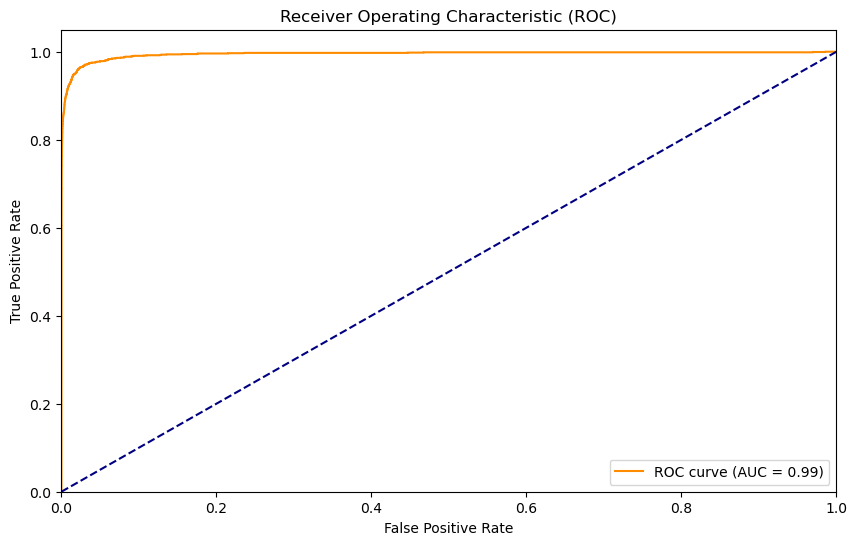

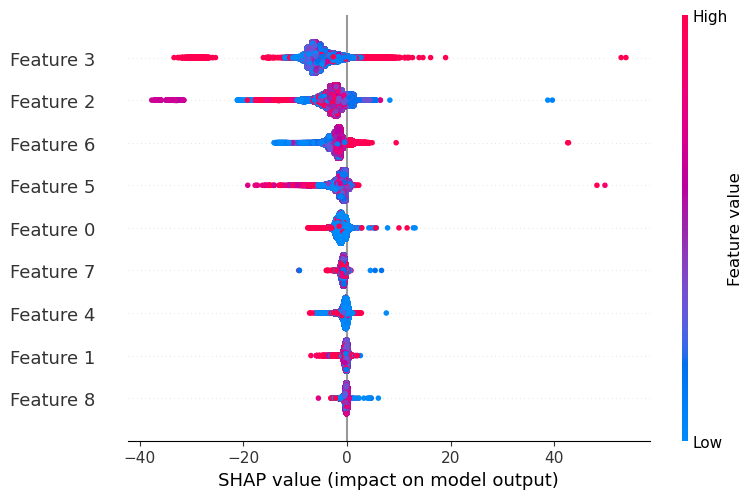

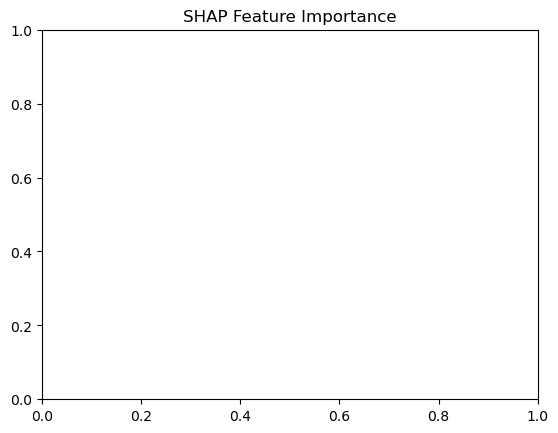

In [52]:
# Main Execution
def main(file_path):
    # Load and Preprocess Data
    X_scaled, y, df = load_and_preprocess_data(file_path)
    
    # Train Supervised Models
    xgb_model, X_test, y_test = train_supervised_models(X_scaled, y)
    
    # Unsupervised Anomaly Detection
    iso_forest, anomalies = train_unsupervised_model(X_scaled)
    
    # Model Evaluation
    roc_auc = model_evaluation_and_visualization(xgb_model, X_test, y_test)
    
    # Model Explainability
    model_explainability(xgb_model, X_test)
    
    return xgb_model, iso_forest

# Placeholder for dataset path - replace with your actual path
dataset_path = 'fraudTrain.csv'
model, anomaly_detector = main(dataset_path)